In [1]:

import os
import numpy as np
import pandas as pd
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


2025-09-05 18:04:08.746316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757095449.020637      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757095449.108270      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# %% [code]
paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input/toronto-emotional-speech-set-tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        # extract label from filename
        label = filename.split('_')[-1].split('.')[0]
        labels.append(label.lower())

print("Total samples:", len(paths))

# Create dataframe
df = pd.DataFrame({'speech': paths, 'label': labels})
df['label'].value_counts()


Total samples: 5600


label
fear       800
angry      800
disgust    800
neutral    800
sad        800
ps         800
happy      800
Name: count, dtype: int64

In [3]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [4]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [5]:
import pandas as pd
df=pd.DataFrame()
df['speech']=paths
df['label']=labels
df.head()

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


# Exploratory Data Analysis

In [6]:
def waveplot(data, sr , emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
def spect(data, sr, emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion)
    librosa.display.specshow(xdb, sr=sr , x_axis='time', y_axis='hz')
    plt.colorbar()

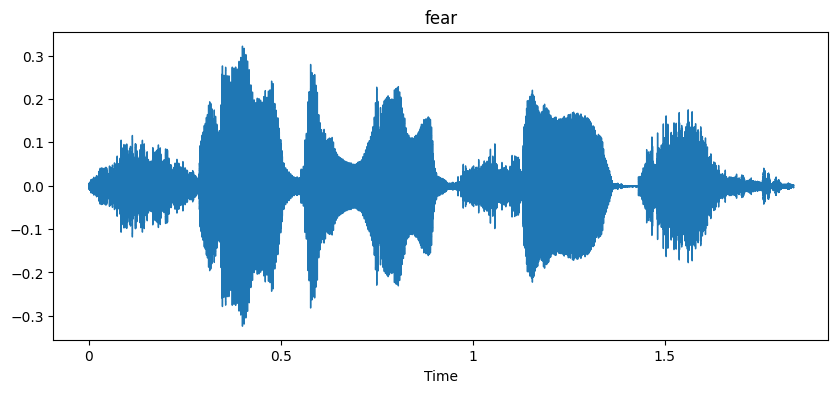

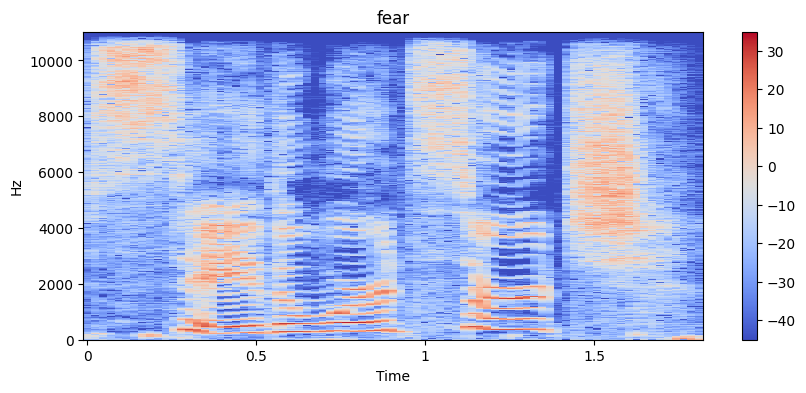

In [7]:
emotion='fear'
path=np.array(df['speech'][df['label']==emotion])[3]
data , sampling_rate= librosa.load(path)
waveplot(data , sampling_rate, emotion)
spect(data , sampling_rate, emotion)
Audio(path)

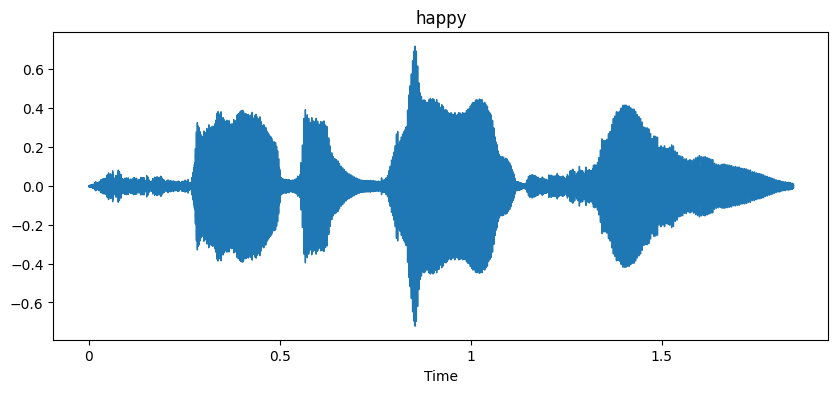

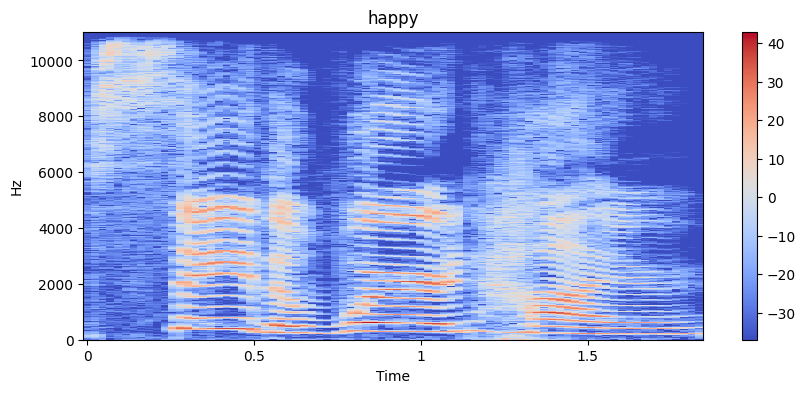

In [8]:
emotion='happy'
path=np.array(df['speech'][df['label']==emotion])[7]
data , sampling_rate= librosa.load(path)
waveplot(data , sampling_rate, emotion)
spect(data , sampling_rate, emotion)
Audio(path)

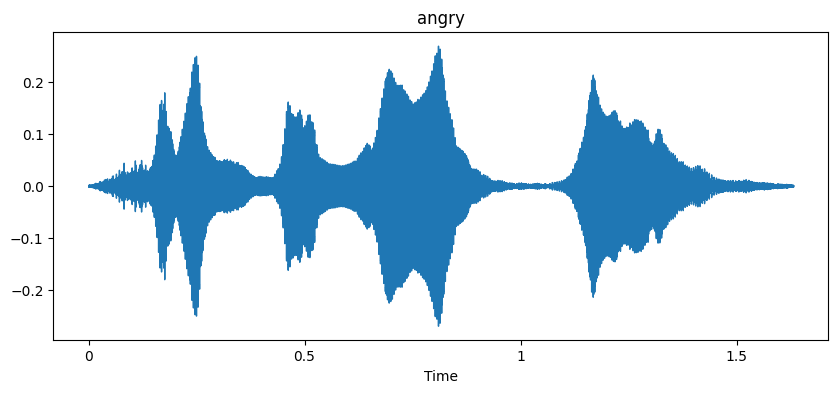

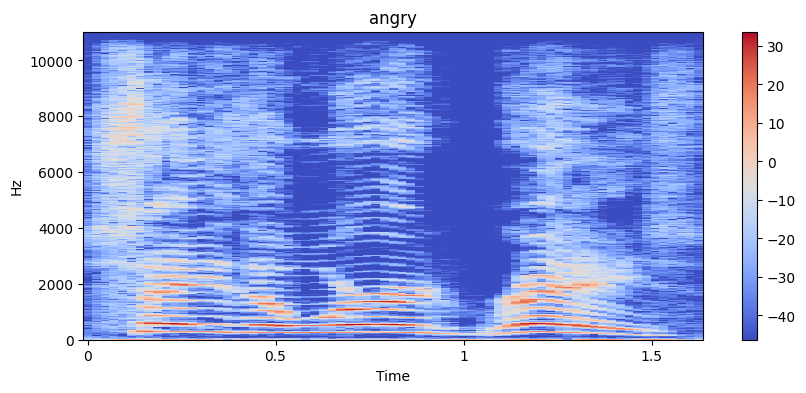

In [9]:
emotion='angry'
path=np.array(df['speech'][df['label']==emotion])[9]
data , sampling_rate= librosa.load(path)
waveplot(data , sampling_rate, emotion)
spect(data , sampling_rate, emotion)
Audio(path)

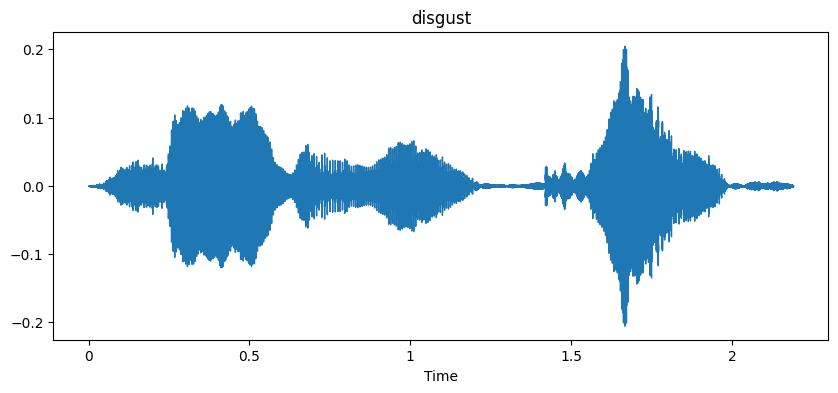

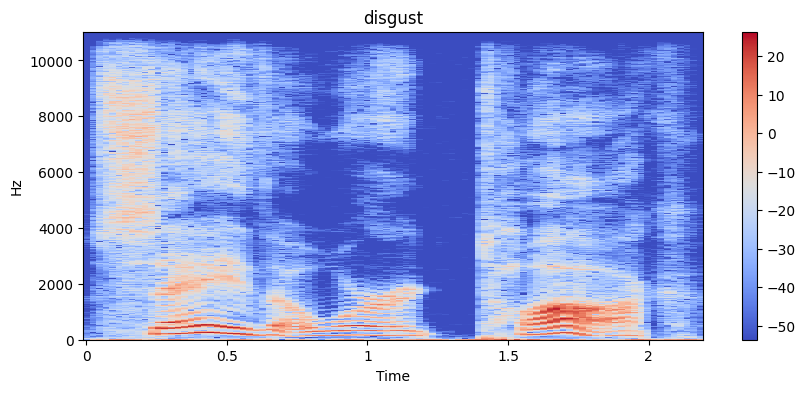

In [10]:
emotion='disgust'
path=np.array(df['speech'][df['label']==emotion])[9]
data , sampling_rate= librosa.load(path)
waveplot(data , sampling_rate, emotion)
spect(data , sampling_rate, emotion)
Audio(path)

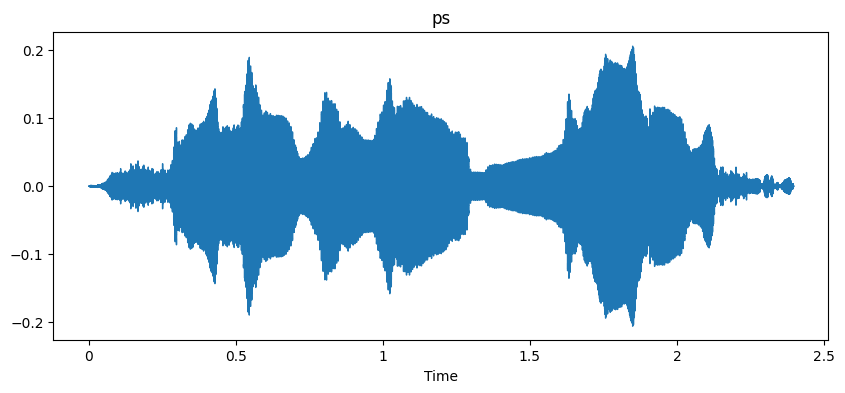

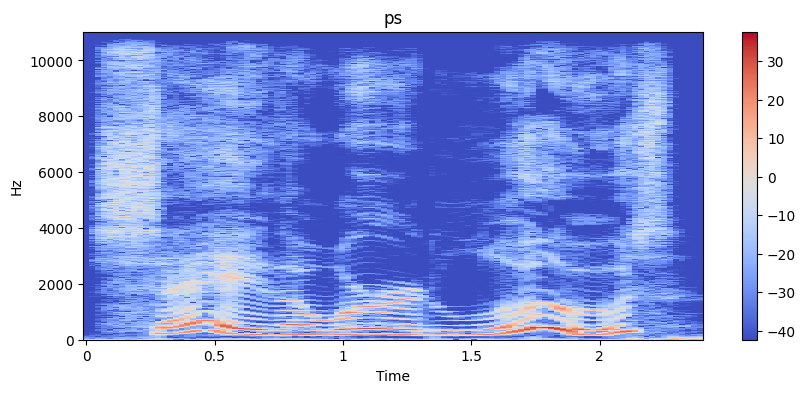

In [11]:
emotion='ps'
path=np.array(df['speech'][df['label']==emotion])[9]
data , sampling_rate= librosa.load(path)
waveplot(data , sampling_rate, emotion)
spect(data , sampling_rate, emotion)
Audio(path)

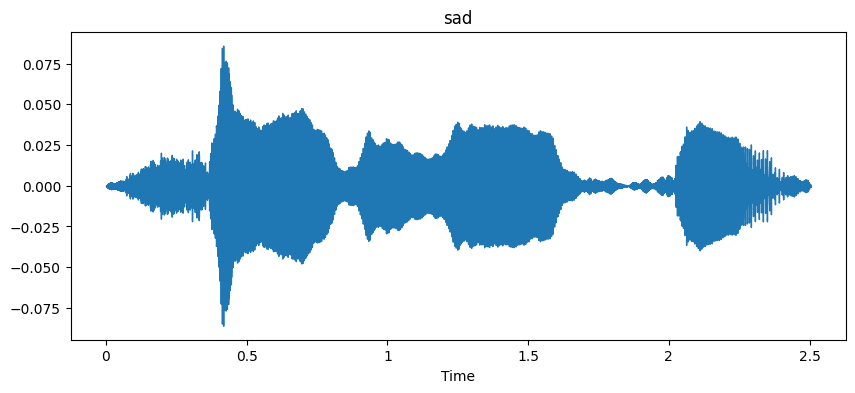

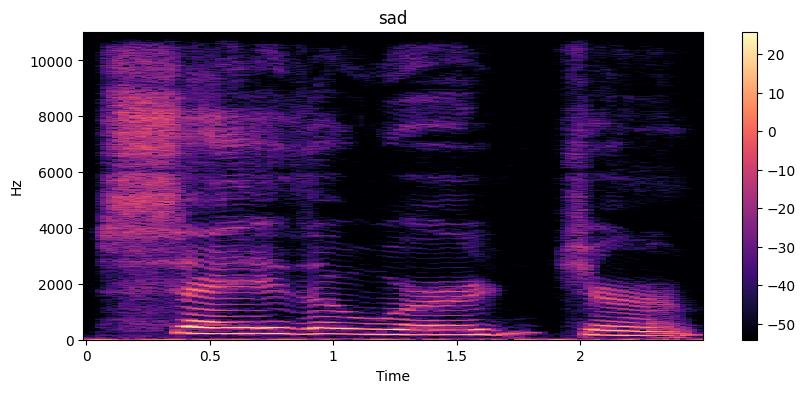

In [12]:
emotion='sad'
path=np.array(df['speech'][df['label']==emotion])[0]
data , sampling_rate= librosa.load(path)
waveplot(data , sampling_rate, emotion)
spect(data , sampling_rate, emotion)
Audio(path)

# Feature Extraction

In [13]:
# %% [code]
def extract_mfcc(filename, max_len=130):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T
    
    if len(mfcc) < max_len:
        pad_width = max_len - len(mfcc)
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_len, :]
    
    return mfcc


In [14]:
extract_mfcc(df['speech'][0])

array([[-303.7494   ,  185.85135  ,   55.25637  , ...,   -2.841601 ,
          -7.8804407,   -1.8880582],
       [-231.68332  ,  193.26125  ,   40.189297 , ...,  -15.468765 ,
         -10.255207 ,   -5.554656 ],
       [-211.75569  ,  176.0441   ,   23.791597 , ...,  -13.394371 ,
           2.977274 ,   -7.1338024],
       ...,
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)

In [15]:
# %% [code]
# Apply MFCC extraction
x_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
X = np.array([x for x in x_mfcc])  # shape: (n_samples, 130, 40)
 # add channel dim if needed (n_samples, 130, 40, 1)
print("Feature shape:", X.shape)


Feature shape: (5600, 130, 40)


In [16]:
# %% [code]
# Encode labels
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(df[['label']])
print("Label shape:", y.shape)
print("Classes:", enc.categories_)


Label shape: (5600, 7)
Classes: [array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
      dtype=object)]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
# %% [code]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])
print(X_train.shape, X_test.shape)

Train samples: 4480
Test samples: 1120
(4480, 130, 40) (1120, 130, 40)


# creating  LSTM model

In [18]:
# %% [code]
model = Sequential([
    LSTM(128, input_shape=(130, 40), return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')  # number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1757095609.405345      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757095609.405983      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,007 (406.28 KB)

 Trainable params: 104,007 (406.28 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# %% [code]
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# %% [code]
history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=64,
    shuffle=True,
    callbacks=[checkpoint, es]
)


Epoch 1/100


I0000 00:00:1757095614.210575     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2262 - loss: 1.8291 - val_accuracy: 0.4159 - val_loss: 1.2077
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4645 - loss: 1.1842 - val_accuracy: 0.6354 - val_loss: 0.7197
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6634 - loss: 0.7240 - val_accuracy: 0.7656 - val_loss: 0.5467
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7569 - loss: 0.5414 - val_accuracy: 0.7924 - val_loss: 0.4370
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8235 - loss: 0.3814 - val_accuracy: 0.8594 - val_loss: 0.2599
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8409 - loss: 0.2965 - val_accuracy: 0.7768 - val_loss: 1.8734
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7786 - loss: 0.6562 - val_accuracy: 0.8132 - val_loss: 0.3950
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8416 - loss: 0.3155 - val_accuracy: 0.8601 - val_l

# Ploting the results

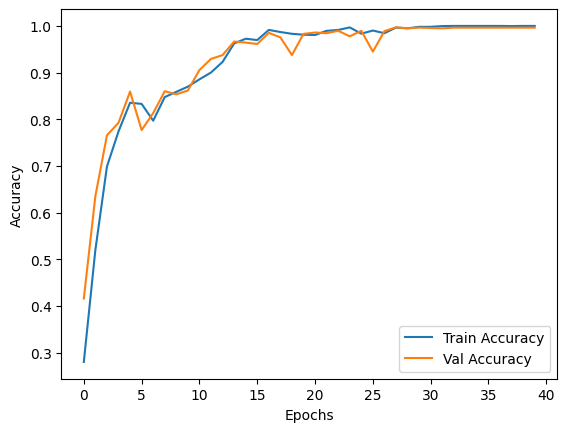

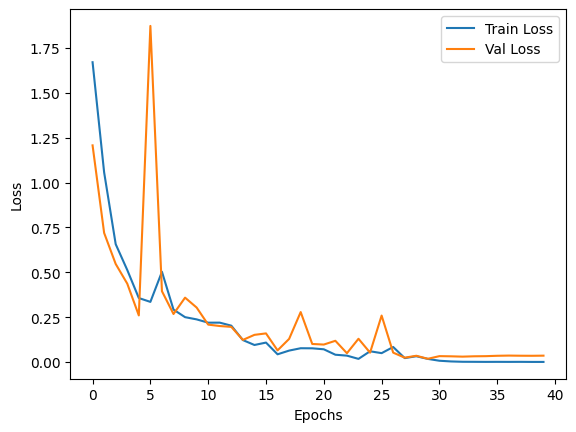

In [20]:
# %% [code]
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# loss

# Prediction

In [21]:
df['label'].value_counts()

label
fear       800
angry      800
disgust    800
neutral    800
sad        800
ps         800
happy      800
Name: count, dtype: int64

In [22]:
print(enc.categories_)

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
      dtype=object)]


In [23]:
rand_idx = np.random.randint(0, len(X))
sample = X[rand_idx:rand_idx+1]  # shape (1, 130, 40)
pred = model.predict(sample)
pred_class = np.argmax(pred)
true_class = np.argmax(y[rand_idx])

print("Actual:", enc.categories_[0][true_class])
print("Predicted:", enc.categories_[0][pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Actual: sad
Predicted: sad


In [24]:
# Make sure X_test shape is correct
pred = model.predict(X_test)             # (n_samples, 7)
pred_classes = np.argmax(pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(true_classes, pred_classes, target_names=enc.categories_[0]))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
              precision    recall  f1-score   support

       angry       1.00      0.98      0.99       160
     disgust       1.00      0.99      0.99       160
        fear       0.99      1.00      0.99       160
       happy       0.99      1.00      0.99       160
     neutral       1.00      1.00      1.00       160
          ps       0.99      0.99      0.99       160
         sad       0.99      1.00      0.99       160

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120



In [25]:
import librosa
import numpy as np

y, sr = librosa.load('/kaggle/input/recording2/Record (online-voice-recorder.com) (1).mp3', duration=3, offset=0)
y = y / np.max(np.abs(y))  # normalize
x_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T

if x_mfcc.shape[0] < 130:
    pad_width = 130 - x_mfcc.shape[0]
    x_mfcc = np.pad(x_mfcc, ((0,pad_width),(0,0)), mode='constant')
else:
    x_mfcc = x_mfcc[:130, :]

x_input = np.expand_dims(x_mfcc, axis=0)
pred = model.predict(x_input)
pred_class = np.argmax(pred)
print("Predicted:", enc.categories_[0][pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: sad


In [26]:
import librosa
import numpy as np
from keras.models import load_model
from IPython.display import Audio

# Load your trained model
model = load_model('best_model.h5')

# If you don't have a saved encoder, create it from your training labels
from sklearn.preprocessing import OneHotEncoder

# Suppose `df['label']` contains your training labels
enc = OneHotEncoder(sparse=False)
y_encoded = enc.fit_transform(df[['label']])  

# Check categories
print("Label categories:", enc.categories_)


Label categories: [array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
      dtype=object)]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [27]:
import librosa
import numpy as np
from IPython.display import Audio

# -------------------------
# 1) Normalize audio
# -------------------------
def normalize_audio(y):
    return y / np.max(np.abs(y))

# -------------------------
# 2) Extract MFCC for real-world audio
# -------------------------
def extract_mfcc_real(y, sr, max_len=130, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T  # shape (time, n_mfcc)
    if mfcc.shape[0] < max_len:
        pad_width = max_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_len, :]
    return mfcc

# -------------------------
# 3) Predict emotion
# -------------------------
def predict_emotion_real(filename, window_sec=3, hop_sec=1):
    # Load audio
    y, sr = librosa.load(filename, sr=None)
    y = normalize_audio(y)

    window_len = int(window_sec * sr)
    hop_len = int(hop_sec * sr)

    predictions = []

    # Split audio into sliding windows
    for start in range(0, len(y), hop_len):
        end = start + window_len
        if end > len(y):
            break
        y_slice = y[start:end]
        x_mfcc = extract_mfcc_real(y_slice, sr)
        x_input = np.expand_dims(x_mfcc, axis=0)  # (1, time, n_mfcc)
        pred = model.predict(x_input, verbose=0)
        predictions.append(pred[0])  # emotion output (assuming model returns [emotion, gender])

    if len(predictions) == 0:
        return "Audio too short to predict"

    # Average predictions over all windows
    avg_pred = np.mean(predictions, axis=0)
    pred_class = np.argmax(avg_pred)
    pred_emotion = enc.categories_[0][pred_class]

    return pred_emotion

# -------------------------
# 4) Test on real-world audio
# -------------------------
fname = '/kaggle/input/recording2/Record (online-voice-recorder.com) (1).mp3'
predicted_emotion = predict_emotion_real(fname)
print("Predicted emotion:", predicted_emotion)

Audio(fname)


Predicted emotion: sad


In [29]:
# Save the entire model (architecture + weights + optimizer state)
model.save("emotion_model.h5")
